In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# local imports
from src import Compose_Event, Draw_Compose_Event
from src import SttCSVReader, Draw_Reader_Event

### _Dataset_

In [6]:
# mu+mu- data (current)
input_dir = 'train_quick'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
file_prefixes[:10]

['train_quick/event0000000000',
 'train_quick/event0000000001',
 'train_quick/event0000000002',
 'train_quick/event0000000003',
 'train_quick/event0000000004',
 'train_quick/event0000000005',
 'train_quick/event0000000006',
 'train_quick/event0000000007',
 'train_quick/event0000000008',
 'train_quick/event0000000009']

In [19]:
event_id = 9464
event_prefix = file_prefixes[event_id]

In [20]:
event_prefix

'train_quick/event0000009464'

In [21]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000009464 memory usage 0.01 MB


In [22]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id
0,1,-16.618999,-8.585,35.0,9,0,35,0
1,2,-16.618999,-9.595,35.0,9,0,36,1
2,3,-17.493700,-10.100,35.0,9,1,142,2
3,4,-18.368401,-10.605,35.0,9,2,254,3
4,5,-19.243099,-11.110,35.0,9,3,372,4


In [23]:
tubes.head()

,hit_id,depcharge,energyloss,volume_id,layer_id,module_id,sector_id,isochrone,skewed
0,1,5432110.0,5.43211,9,0,35,1,0.408555,0
1,2,14853600.0,14.85360,9,0,36,2,0.386703,0
2,3,22240000.0,22.24000,9,1,142,2,0.281683,0
3,4,8826100.0,8.82610,9,2,254,2,0.145052,0
4,5,10613800.0,10.61380,9,3,372,2,0.047061,0


In [24]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary
0,7,-2.75798,-2.9582,10.6212,-0.116317,-0.026607,0.152035,-1,1,-211,0.742858,1
1,7,-2.75798,-2.9582,10.6212,-0.116317,-0.026607,0.152035,-1,1,-211,0.742858,1
2,7,-2.75798,-2.9582,10.6212,-0.116317,-0.026607,0.152035,-1,1,-211,0.742858,1
3,7,-2.75798,-2.9582,10.6212,-0.116317,-0.026607,0.152035,-1,1,-211,0.742858,1
4,7,-2.75798,-2.9582,10.6212,-0.116317,-0.026607,0.152035,-1,1,-211,0.742858,1


In [25]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-16.373400,-8.93365,29.684700,-0.093307,-0.065716,0.144058,1.0,7
1,2,-16.850901,-9.27533,30.424700,-0.092380,-0.066971,0.143984,1.0,7
2,3,-17.661400,-9.88110,31.702200,-0.090550,-0.069325,0.143934,1.0,7
3,4,-18.450300,-10.50410,32.971600,-0.088499,-0.071810,0.143923,1.0,7
4,5,-19.215799,-11.14190,34.227699,-0.086831,-0.074231,0.143661,1.0,7


### _Compose Event_

- Same as `select_hits()` in `processing/utils/event_utils.py`

In [26]:
event = Compose_Event(event_prefix,skewed=False)

In [27]:
event.shape

(969, 27)

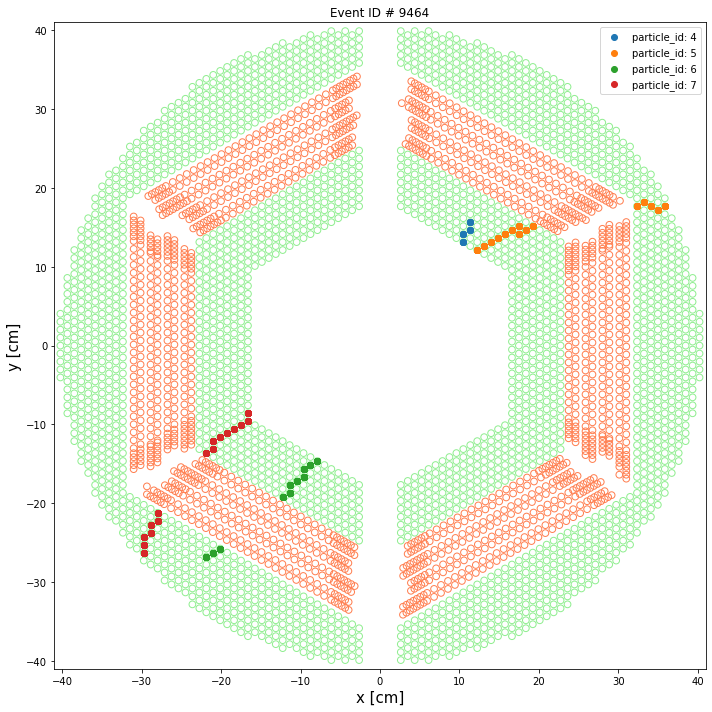

In [28]:
Draw_Compose_Event(event,figsize=(10, 10),save_fig=False);

### SttCSVReader

In [18]:
csv_reader = SttCSVReader(input_dir, True, True)

In [19]:
data = csv_reader(1)

In [20]:
data.hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id,isochrone,skewed,sector_id,event_id
0,1,-5.24811,16.160000,35.0,9,0,4,0,0.157567,0,0,1
1,2,-5.24811,17.170000,35.0,9,1,108,1,0.335169,0,0,1
2,3,-6.12280,17.674999,35.0,9,2,219,2,0.443259,0,0,1
3,4,-5.24811,18.180000,35.0,9,2,218,3,0.481668,0,0,1
4,5,-6.12280,18.684999,35.0,9,3,335,4,0.312505,0,0,1


In [21]:
data.hits.shape

(28, 12)

In [22]:
csv_reader = SttCSVReader(input_dir, True, False)

In [23]:
data = csv_reader(event_id)

In [24]:
data.hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id,isochrone,skewed,sector_id,event_id,layer
0,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,1,9646,0
1,287,16.618999,7.575,35.0,9,0,86,286,0.338998,0,4,9646,0
2,288,16.618999,8.585,35.0,9,0,87,287,0.087321,0,4,9646,0
3,289,15.744300,10.100,35.0,9,0,89,288,0.013796,0,5,9646,0
4,290,14.869700,10.605,35.0,9,0,90,289,0.478806,0,5,9646,0


In [25]:
data.hits.shape

(212, 13)

In [26]:
data.hits.layer_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25], dtype=int32)

In [27]:
data.hits.layer.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [28]:
data.event_file

'/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000009646'

In [29]:
data.event.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id,isochrone,skewed,...,start_time,primary,pt,peta,r,phi,eta,r3,absZ,tpt
0,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,...,0.090042,1,0.080037,1.407185,16.990803,-2.932008,1.470124,38.906136,35.0,0.076753
1,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,...,0.090042,1,0.080037,1.407185,16.990803,-2.932008,1.470124,38.906136,35.0,0.076753
2,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,...,0.090042,1,0.080037,1.407185,16.990803,-2.932008,1.470124,38.906136,35.0,0.076753
3,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,...,0.090042,1,0.080037,1.407185,16.990803,-2.932008,1.470124,38.906136,35.0,0.076753
4,1,-16.618999,-3.535,35.0,9,0,30,0,0.025101,0,...,0.090042,1,0.080037,1.407185,16.990803,-2.932008,1.470124,38.906136,35.0,0.076753


In [30]:
data.particles

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
1,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
2,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
3,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
4,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
305,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
306,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185
307,7,-0.103115,0.216376,1.08903,-0.079442,0.009739,0.153655,-1,1,-211,0.090042,1,0.080037,1.407185


In [32]:
data.particles.pt

0      0.080037
1      0.080037
2      0.080037
3      0.080037
4      0.080037
         ...   
304    0.080037
305    0.080037
306    0.080037
307    0.080037
308    0.080037
Name: pt, Length: 309, dtype: float32

## _Detector Layout_

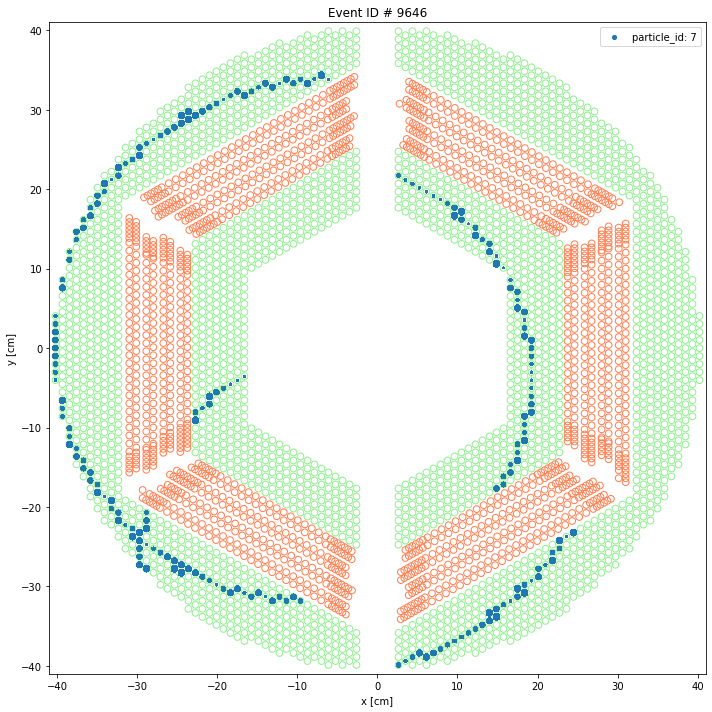

In [34]:
Draw_Reader_Event(data,figsize=(10, 10));

In [32]:
# path to HDF5 Store
hdf5_path = 'run/trkx_reco_eval/eval_particles.h5'

In [33]:
# Method 1: use context manager to open store
with pd.HDFStore(hdf5_path, 'r') as store:
    print(store)

<class 'pandas.io.pytables.HDFStore'>
File path: run/trkx_reco_eval/eval_particles.h5



In [34]:
# Method 2: Use constructor method. Don't forget to close it using store.close()
store = pd.HDFStore(hdf5_path)

In [35]:
store.groups()

[/data (Group) ''
   children := ['axis0' (Array), 'axis1' (Array), 'block0_items' (Array), 'block0_values' (Array), 'block1_items' (Array), 'block1_values' (Array), 'block2_items' (Array), 'block2_values' (Array), 'block3_items' (Array), 'block3_values' (Array), 'block4_items' (Array), 'block4_values' (VLArray)]]

In [36]:
# get stored dataframe using group
store.get('data').head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,6,0.461538,18,True,True,900
1,9,0.073745,15,True,True,900
2,8,0.510547,17,True,True,900
3,4,0.712900,17,True,True,900
4,2,0.650417,18,True,True,900


In [37]:
# OR, get stored dataframe using group
store['data'].head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,6,0.461538,18,True,True,900
1,9,0.073745,15,True,True,900
2,8,0.510547,17,True,True,900
3,4,0.712900,17,True,True,900
4,2,0.650417,18,True,True,900


In [38]:
store.close()

In [39]:
store.is_open

False

In [40]:
# Method 3: Retrieve pandas object stored in h5 file
store = pd.read_hdf(hdf5_path)

In [41]:
store.head()

,particle_id,pt,n_true_hits,is_matched,is_trackable,evtid
0,6,0.461538,18,True,True,900
1,9,0.073745,15,True,True,900
2,8,0.510547,17,True,True,900
3,4,0.712900,17,True,True,900
4,2,0.650417,18,True,True,900
